## Implementation of a stacked Classifier

## Evaluating the Model

In [2]:
from pipeline import pipeline
from chris import ldData, mlpClassification, makeTrainValSet, balanceStupid, NO_DISPLAY_savePred
from olin import stackedClassification, ecgExtractOlinFFT, ecgExtractOlinFFT12
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
from heinrich import inv, crop, ecgExtract, rfClassification
from anova import anova

In [ ]:

hyper = { 
    
    "inv_threshold": 0.6, 
    "crop_location": 300,
    "mlpClassification_epochs": 200,
    "mlpClassification_useValidationSet": True,
    "mlpClassification_makePrediction": False,
    "makeTrainValSet_valPercent": 0.1,
    "rfClassification_depth": 4,
    "rfClassification_useValidationSet": True,
    "rfClassification_makePrediction": False,
    "anova_percentage": 0.7,
    "stackedClf_useValidationSet": True,
    "stackedClf_makePrediction": False,
    "used_cached_stats": True
    
}

# ecgExtractOlinFFT -> 20 fourier features
# ecgExtractOlinFFT35 -> 35 fourier features

#data = pipeline([ ldData, crop, inv, ecgExtractOlinC, rfClassification, NO_DISPLAY_savePred ], hyper, save_states_to_cache=True)
data = pipeline([ ldData, crop, inv, ecgExtractOlinFFT12, makeTrainValSet, rfClassification ], hyper, save_states_to_cache=True)

print( "train losses" )
data["train_losses"]
print( "val losses" )
data["val_losses"]

  0%|          | 2/5116 [00:00<04:40, 18.20it/s]

[Pipeline] Saved state found: ./cache/ldData()_crop(300)_inv(0.6), starting from function: ecgExtractOlinFFT12
[Pipeline] executing: ecgExtractOlinFFT12()
extracting from X_train


100%|█████████▉| 5097/5116 [03:39<00:00, 23.27it/s]

In [3]:
data["train_losses"]

array([0.00065147, 0.00065147])

In [4]:
data["val_losses"]

array([0.15820312, 0.15820312])

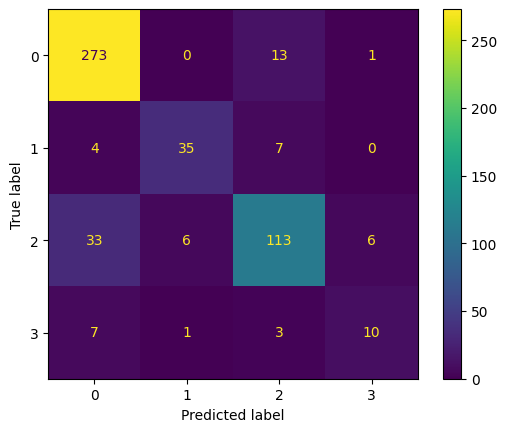

In [5]:
from olin_utils import confMat
_, misclass = confMat( data[ "y_val_hat" ], np.transpose( data[ "y_val" ])[ 0 ], visualize = True ) # this is the one with additionaly differences between periods lengths

## Additional Features: FFT

In [47]:
def moving_avg_smoothing(ts, left_window, right_window):
    ts = np.array(ts)
    
    new_ts = ts
    for idx in range(left_window, len(ts)-right_window):
        window = ts[idx-left_window : idx+right_window]
        if len(window) == 0:
            avg = 0
        else:
            avg = window.mean() #np.median(window)
            
        new_ts[idx] = avg
    new_ts = new_ts[left_window:-right_window]
    return new_ts



[Pipeline] This is no new run. It already exists at location ./cache/ldData()_crop(300)_inv(0.6).pkl. Returning data_dict anyways.
[-56. -58. -60. ...   6.   3.   0.]


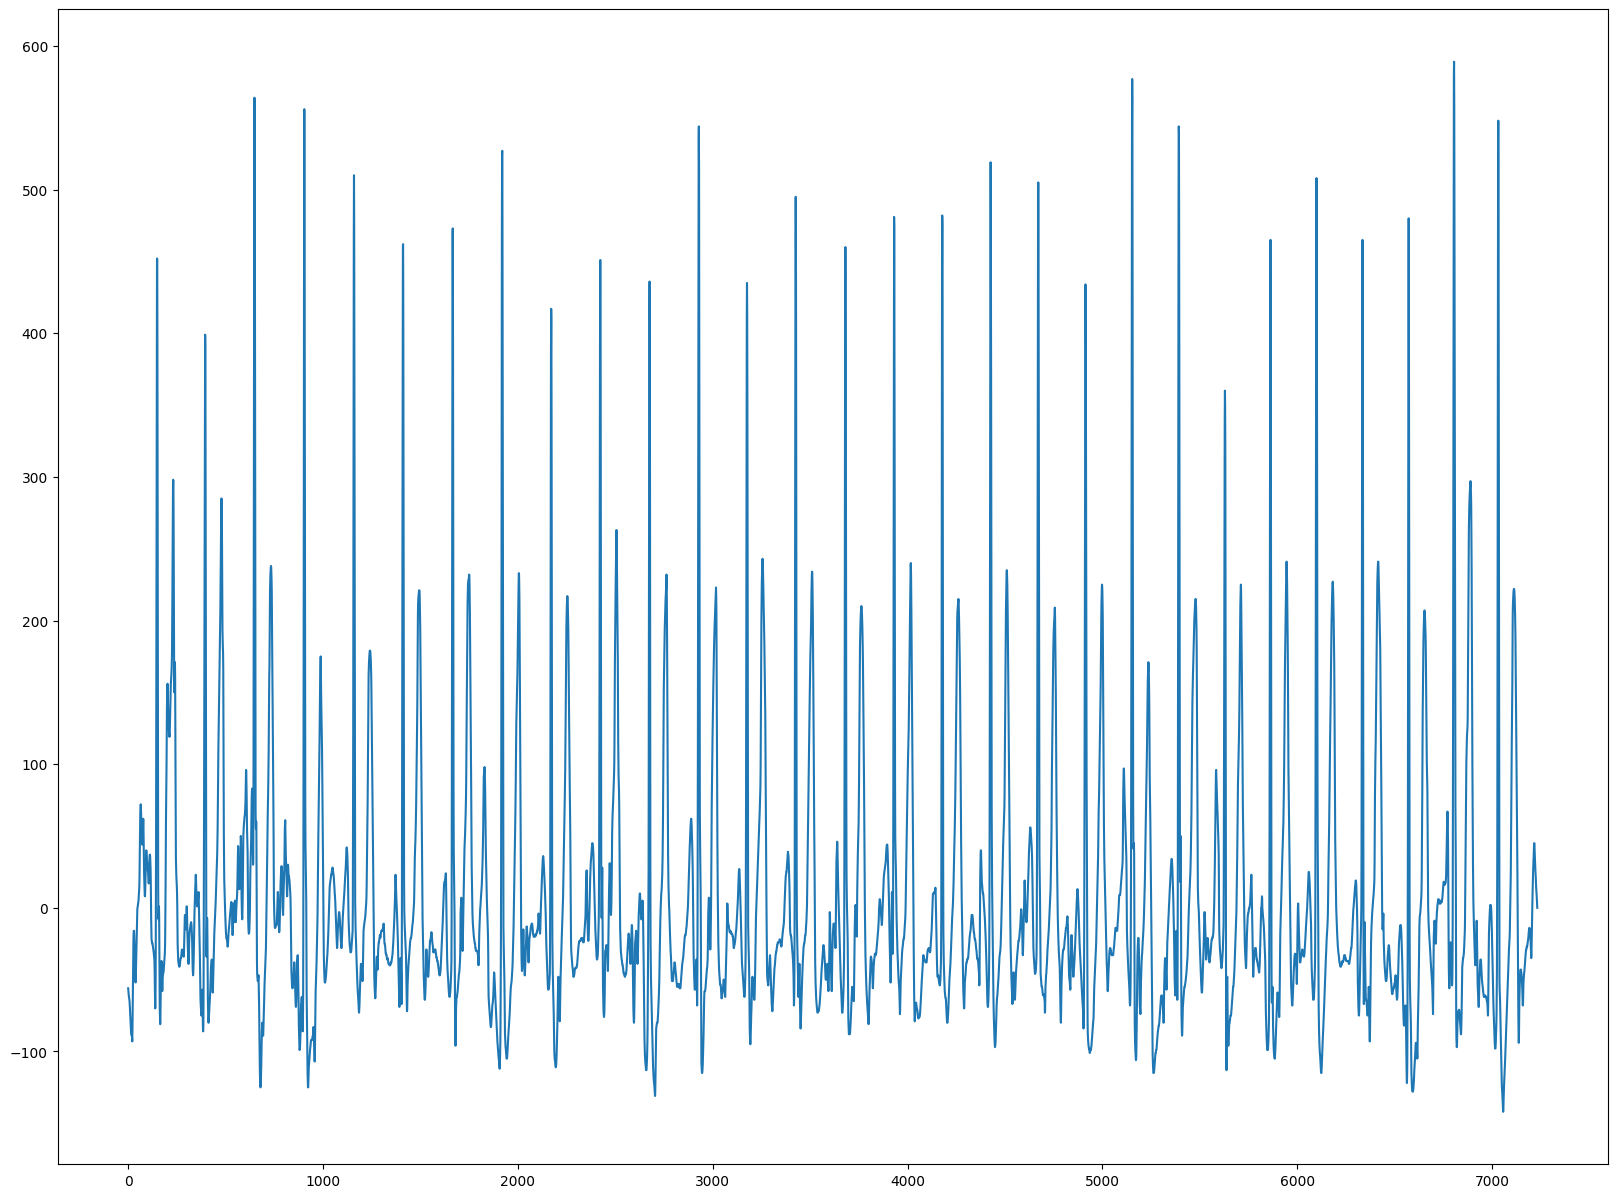

In [158]:
hyper = {}
feat_data = pipeline([ ldData, crop, inv], hyper)
this_ts = feat_data["X_train"][0][:7233]
print(this_ts)
plt.plot(this_ts)

7200
24
300
[(3.583333333333333, 137345.12), (2.375, 94558.74), (3.7916666666666665, 93958.266), (3.5416666666666665, 89938.45), (1.2083333333333333, 84761.56), (7.125, 80905.125), (4.75, 80278.06), (2.5416666666666665, 74596.12), (7.166666666666666, 72561.01), (2.4166666666666665, 68222.25), (3.833333333333333, 63498.664), (2.5, 61428.688)]
[3.58, 2.38, 3.79, 3.54, 1.21, 7.12, 4.75, 2.54, 7.17, 2.42, 3.83, 2.5]


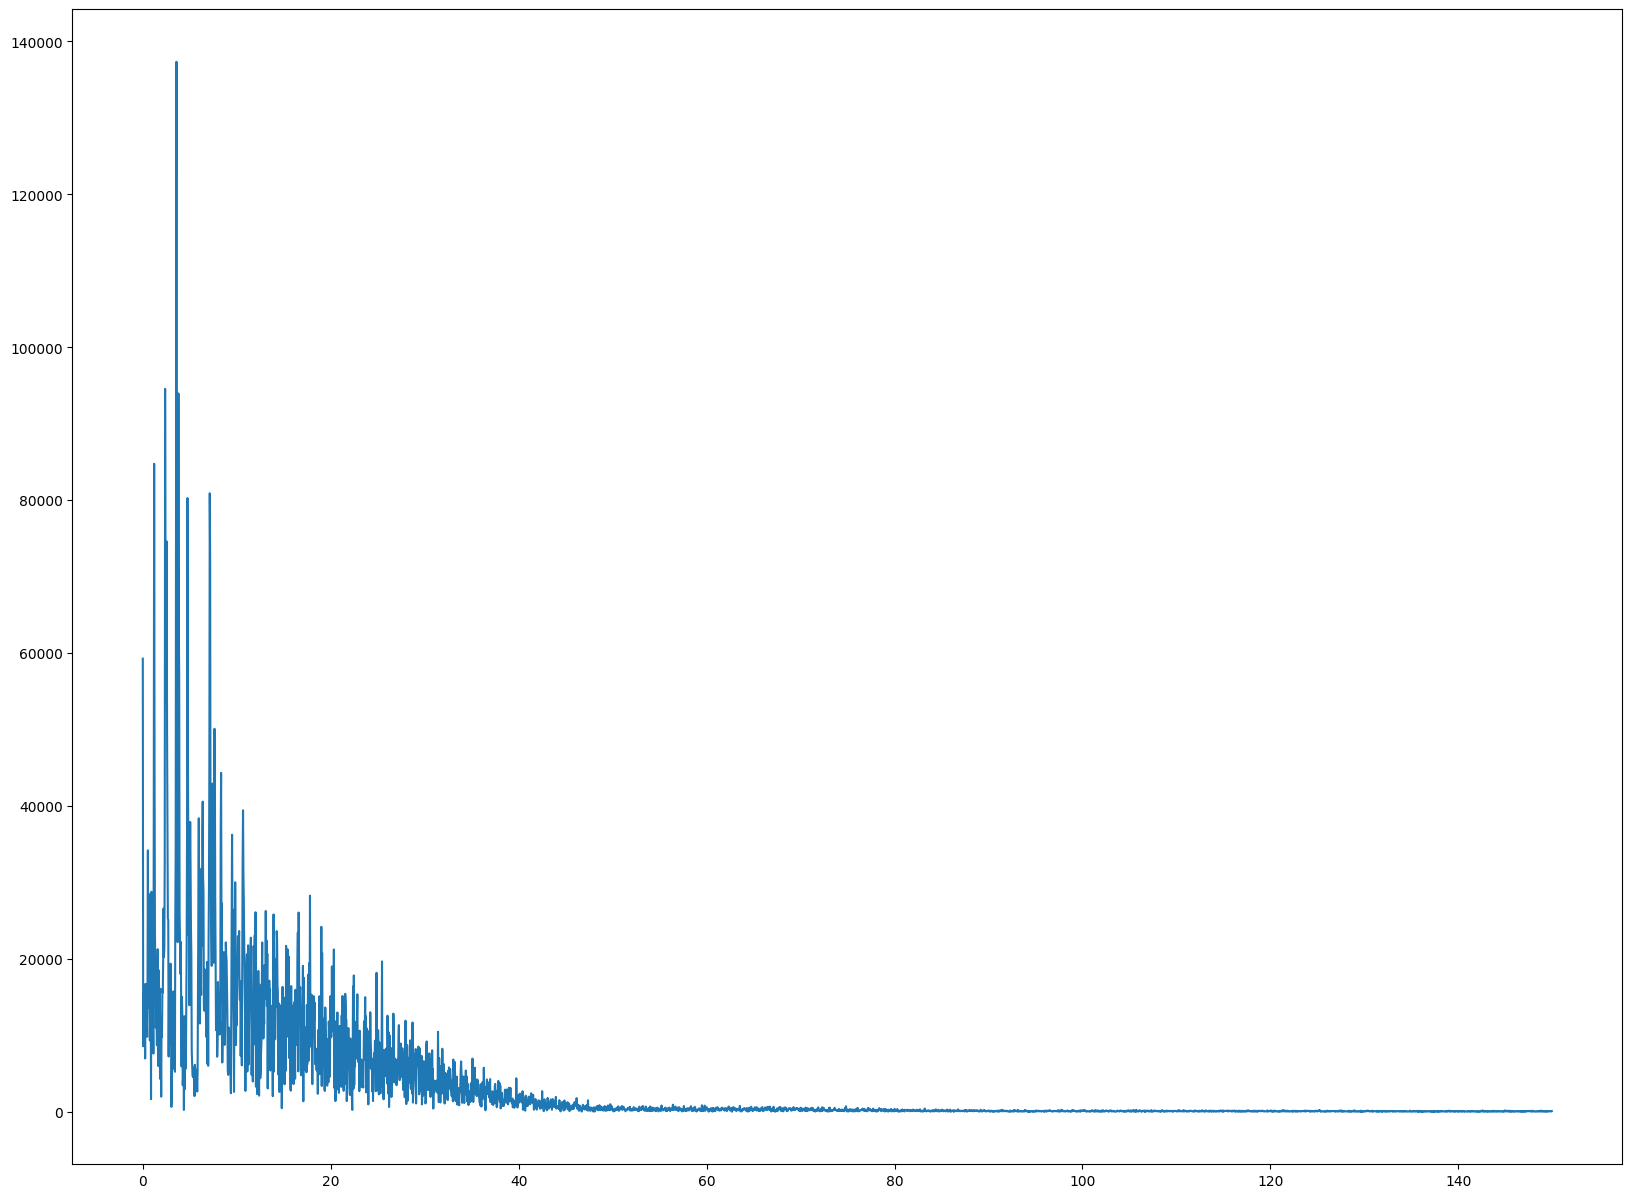

In [159]:
from scipy.fft import fft, fftfreq
import matplotlib

matplotlib.rc('figure', figsize=(20, 15))

nr_freq = 12

SAMPLE_RATE = 300
DURATION = int(len(this_ts)/SAMPLE_RATE)
this_ts_mod = this_ts[:300*int(len(this_ts)/SAMPLE_RATE)]

#plt.plot(this_ts_mod)
# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION
print(N)
print(DURATION)
print(SAMPLE_RATE)

yf = fft(this_ts_mod)
xf = fftfreq(N, 1 / SAMPLE_RATE)

# also add the width of the distribution of frequencies


# get the largest frequencies
pos_xf = xf[:int(len(xf)/2)]
pos_yf = np.abs(yf)[:int(len(xf)/2)]

tups = zip(pos_xf, pos_yf)
sorted_tups = sorted(tups, key=lambda x: x[1], reverse=True)[:nr_freq]
print(sorted_tups)
most_important_freq = [round(freq, 2) for freq, intensity in sorted_tups]   # feed this as feature
print(most_important_freq)


plt.plot(xf[:int(len(xf)/2)], np.abs(yf)[:int(len(xf)/2)])
#plt.plot(sorted_tups)
plt.show()

## Predicting with the Model

In [6]:

hyper2 = { 
    
    "inv_threshold": 0.6, 
    "crop_location": 300,
    "mlpClassification_epochs": 200,
    "mlpClassification_useValidationSet": True,
    "mlpClassification_makePrediction": False,
    "makeTrainValSet_valPercent": 0.1,
    "rfClassification_depth": 4,
    "rfClassification_useValidationSet": False,
    "rfClassification_makePrediction": True,
    "anova_percentage": 0.7,
    "stackedClf_useValidationSet": True,
    "stackedClf_makePrediction": False,
    "used_cached_stats": True
    
}
data = pipeline([ ldData, crop, inv, ecgExtractOlinFFT35, rfClassification, NO_DISPLAY_savePred ], hyper2, save_states_to_cache=True)

[Pipeline] Saved state found: ./cache/ldData()_crop(300)_inv(0.6)_ecgExtractOlinFFT35(), starting from function: rfClassification
[Pipeline] executing: rfClassification(4,False,True)


/usr/local/share/miniconda/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

## Best so far - Heinrich



[Pipeline] This is no new run. It already exists at location ./cache/ldData()_crop(300)_inv(0.6)_ecgExtract()_makeTrainValSet(0.1)_rfClassification(7,True,False).pkl. Returning data_dict anyways.
train_losses
val losses
[0.16601562 0.16601562]


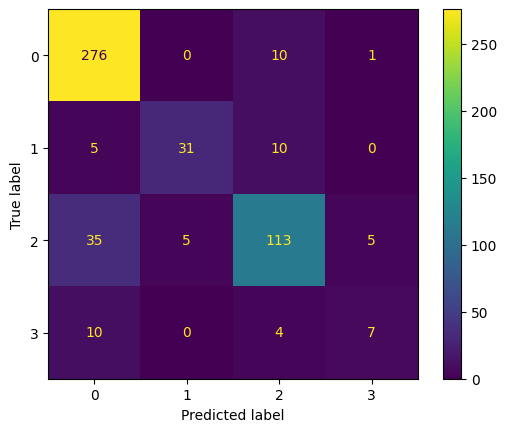

In [19]:
# Heinrichs baseline!

hyper3 = { 
    
    "inv_threshold": 0.6, 
    "crop_location": 300,
    "mlpClassification_epochs": 200,
    "mlpClassification_useValidationSet": True,
    "mlpClassification_makePrediction": False,
    "makeTrainValSet_valPercent": 0.1,
    "rfClassification_depth": 7,
    "rfClassification_useValidationSet": True,
    "rfClassification_makePrediction": False,
    "anova_percentage": 0.7,
    "stackedClf_useValidationSet": True,
    "stackedClf_makePrediction": False,
    "used_cached_stats": True
    
}

data_hein = pipeline([ ldData, crop, inv, ecgExtract, makeTrainValSet, rfClassification ], hyper3, save_states_to_cache=False)
print("train_losses")
data["train_losses"]
print( "val losses" )
print(data["val_losses"])
_, misclass = confMat( data_hein[ "y_val_hat" ], np.transpose( data_hein[ "y_val" ])[ 0 ], visualize = True )